# Naive Bayes Model

The Multinomial Naive Bayes (NB) model is well-suited for the electricity and gas fraud detection dataset because it is designed to handle discrete data, such as counts or frequencies, which are often present in such datasets. Features like consumption patterns, meter readings, or anomalies in usage are naturally represented as numerical values that can be modeled probabilistically. Multinomial NB assumes conditional independence between features, making it computationally efficient for large datasets, and it works well when the features directly correlate with class probabilities, such as detecting fraudulent versus non-fraudulent behavior.

While Categorical NB could be used if features were explicitly categorical (like encoded labels), Multinomial NB is more appropriate here because it directly models numerical distributions and works well with data structured as frequencies or counts, which is typical in fraud detection scenarios.


In [1]:
import pandas as pd
import dask.dataframe as dd
import os

import optuna
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fold_1 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_1.csv')
fold_2 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_2.csv')
fold_3 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_3.csv')
fold_4 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_4.csv')
fold_5 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_5.csv')

smote_fold_1 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_5.csv')

test_set = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/transformed_data/test_set.csv')

In [3]:
train_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4])
val_data = fold_5

display(train_data)
display(val_data)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,1985,2,5,0,0,1,0,0,0,0,...,0.0,12.000000,0.0,0.000000,2.000000,8.000000,6.000000,14.000000,0.000000,0.0
1,1996,12,31,0,0,0,0,0,0,0,...,0.0,53.000000,0.0,10.000000,3.000000,32.000000,34.000000,66.000000,0.000000,0.0
2,1999,9,8,1,0,0,0,0,0,0,...,0.0,19.000000,0.0,14.000000,1.000000,34.000000,0.000000,34.000000,0.000000,0.0
3,2016,4,25,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,6.000000,6.000000,0.000000,6.000000,0.000000,0.0
4,2008,11,22,1,0,0,0,0,0,0,...,0.0,7.000000,0.0,7.000000,16.000000,30.000000,0.000000,30.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40951,2001,5,7,0,0,1,0,0,0,0,...,0.0,29.051793,0.0,10.115537,15.111554,34.665339,19.613545,54.223107,0.055777,1.0
40952,2005,5,11,0,0,0,0,0,0,0,...,0.0,20.270349,0.0,9.719186,26.188954,34.367442,21.811046,56.178488,0.000000,1.0
40953,1984,11,21,0,0,0,0,0,0,0,...,0.0,21.886777,0.0,9.000000,0.238548,31.125325,0.000000,31.125325,0.000000,1.0
40954,2010,6,21,0,0,0,0,0,0,0,...,0.0,12.700108,0.0,8.288482,14.288482,17.638536,17.638536,35.019376,0.257696,1.0


,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,1989,12,29,0,0,0,0,0,0,0,...,0.0,22.0,0.0,5.0,13.0,40.0,0.0,40.0,0.0,0.0
1,1984,11,12,0,0,1,0,0,0,0,...,0.0,52.0,0.0,11.0,3.0,35.0,31.0,66.0,0.0,1.0
2,2010,5,5,1,0,0,0,0,0,0,...,0.0,22.0,0.0,7.0,0.0,17.0,12.0,28.0,1.0,0.0
3,1998,6,23,1,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0,0.0,0.0
4,1999,12,22,0,0,0,0,0,0,0,...,0.0,38.0,0.0,17.0,1.0,34.0,22.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21673,2007,9,6,0,0,0,0,0,0,0,...,0.0,12.0,0.0,11.0,12.0,35.0,0.0,35.0,0.0,0.0
21674,2012,10,13,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0
21675,2018,11,10,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,2.0,3.0,0.0,3.0,0.0,0.0
21676,2010,1,8,0,0,0,0,0,1,0,...,0.0,5.0,0.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0


In [4]:
numerical_features = train_data.drop(columns=['fraud_status', 'region_101',
                   'region_103', 'region_104', 'region_105', 'region_106', 'region_107',
                   'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
                   'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
                   'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
                   'region_371', 'region_372', 'region_379', 'region_399',
                   'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12',
                   'client_catg_51']).columns

numerical_features = list(numerical_features)

print(numerical_features)

['creation_year', 'creation_month', 'creation_day', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_min', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_std', 'consumption_level_2_min', 'consumption_level_2_max', 'consumption_level_2_median', 'consumption_level_2_sum', 'consumption_level_3_mean', 'consumption_level_3_min', 'consumption_level_3_max', 'consumption_level_3_sum', 'consumption_level_4_mean', 'consumption_level_4_min', 'consumption_level_4_max', 'consumption_level_4_median', 'consumption_level_4_sum', 'old_index_mean', 'old_index_min', 'old_index_max', 'old_index_median', 'diff_in_index_mean', 'diff_in_index_std', 'diff_in_index_min', 'diff_in_index_max', 'diff_in_index_sum', 'total_consumption_mean', 'total_consumption_std', 'total_consumption_min', 'total_consumption_max', 'total_consumption_sum', 'months_number_min', 'months_number_max', 'months_number_median', 'meter_number_count', 'meter

In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler with the training data and scale the data.
data_scaled = train_data.copy()
data_scaled[numerical_features] = scaler.fit_transform(data_scaled[numerical_features])

# Display the scaled data
display(data_scaled)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,-1.455290,-1.571095,-1.545187,0,0,1,0,0,0,0,...,-0.002471,-0.452078,-0.03849,-1.206243,-0.888334,-1.160868,-0.462351,-0.961610,-0.077868,0.0
1,-0.436198,1.519945,1.699035,0,0,0,0,0,0,0,...,-0.002471,2.007816,-0.03849,0.382250,-0.804254,0.318692,1.423188,0.994903,-0.077868,0.0
2,-0.158263,0.592633,-1.170854,1,0,0,0,0,0,0,...,-0.002471,-0.032096,-0.03849,1.017647,-0.972415,0.441989,-0.866395,-0.209105,-0.077868,0.0
3,1.416698,-0.952887,0.950368,0,0,0,0,0,0,0,...,-0.002471,-1.172047,-0.03849,-1.206243,-0.552011,-1.284165,-0.866395,-1.262612,-0.077868,0.0
4,0.675540,1.210841,0.576035,1,0,0,0,0,0,0,...,-0.002471,-0.752065,-0.03849,-0.094298,0.288798,0.195396,-0.866395,-0.359606,-0.077868,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40951,0.027026,-0.643783,-1.295632,0,0,1,0,0,0,0,...,-0.002471,0.570986,-0.03849,0.400603,0.214096,0.483006,0.454394,0.551794,-0.046568,1.0
40952,0.397606,-0.643783,-0.796520,0,0,0,0,0,0,0,...,-0.002471,0.044122,-0.03849,0.337643,1.145494,0.464641,0.602376,0.625366,-0.077868,1.0
40953,-1.547935,1.210841,0.451257,0,0,0,0,0,0,0,...,-0.002471,0.141103,-0.03849,0.223401,-1.036439,0.264770,-0.866395,-0.317265,-0.077868,1.0
40954,0.860829,-0.334679,0.451257,0,0,0,0,0,0,0,...,-0.002471,-0.410073,-0.03849,0.110377,0.144892,-0.566668,0.321396,-0.170751,0.066744,1.0


Scaling the features in this fraud detection dataset allows the Multinomial Naive Bayes model to handle numerical features of varying magnitudes in a more balanced and stable way. By using StandardScaler (which normalizes data to have zero mean and unit variance), each feature is treated equally, preventing any one feature from dominating the calculations. This can improve the model's accuracy and consistency.

In [6]:
# Transform the validation data with the scaler
val_data_scaled = val_data.copy()
val_data_scaled[numerical_features] = scaler.transform(val_data_scaled[numerical_features])

# Display the scaled data
display(val_data_scaled)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,-1.084711,1.519945,1.449480,0,0,0,0,0,0,0,...,-0.002471,0.147896,-0.03849,-0.411996,0.036555,0.811879,-0.866395,0.016647,-0.077868,0.0
1,-1.547935,1.210841,-0.671743,0,0,1,0,0,0,0,...,-0.002471,1.947819,-0.03849,0.541099,-0.804254,0.503637,1.221166,0.994903,-0.077868,1.0
2,0.860829,-0.643783,-1.545187,1,0,0,0,0,0,0,...,-0.002471,0.147896,-0.03849,-0.094298,-1.056496,-0.606033,-0.058307,-0.434856,0.483305,0.0
3,-0.250908,-0.334679,0.700813,1,0,0,0,0,0,0,...,-0.002471,-1.112049,-0.03849,-1.047394,-0.972415,-1.469110,-0.866395,-1.375487,-0.077868,0.0
4,-0.158263,1.519945,0.576035,0,0,0,0,0,0,0,...,-0.002471,1.107855,-0.03849,1.494195,-0.972415,0.441989,0.615100,0.618650,-0.077868,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21673,0.582895,0.592633,-1.420409,0,0,0,0,0,0,0,...,-0.002471,-0.452078,-0.03849,0.541099,-0.047526,0.503637,-0.866395,-0.171480,-0.077868,0.0
21674,1.046119,0.901737,-0.546965,0,0,0,0,0,0,0,...,-0.002471,-1.172047,-0.03849,-1.206243,-0.720173,-1.407462,-0.866395,-1.337862,-0.077868,0.0
21675,1.601988,1.210841,-0.921298,0,0,1,0,0,0,0,...,-0.002471,-1.112049,-0.03849,-1.206243,-0.888334,-1.469110,-0.866395,-1.375487,-0.077868,0.0
21676,0.860829,-1.880199,-1.170854,0,0,0,0,0,1,0,...,-0.002471,-0.872060,-0.03849,-1.206243,-1.056496,-1.469110,-0.731714,-1.300237,-0.077868,0.0


### Building the Model

In [7]:
X_train = data_scaled.drop(columns=['fraud_status'])
y_train = data_scaled['fraud_status']

X_test = val_data_scaled.drop(columns=['fraud_status'])
y_test = val_data_scaled['fraud_status']

In [8]:
# Take a 50% sample of the training data for tuning
sample_size = int(0.5 * len(X_train))
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[sample_indices]
y_sample = y_train.iloc[sample_indices]

For the Multinomial Naive Bayes model, key hyperparameters include alpha (smoothing parameter) and fit_prior (whether to learn class priors or use a uniform distribution). These hyperparameters can significantly influence the model's performance, particularly with imbalanced datasets or features of varying importance.

Optuna: Narrows down parameter ranges, saving computation time.
GridSearchCV: Ensures thorough testing of all parameter combinations within a focused range, leading to precise results.
By combining Optuna's efficiency with GridSearchCV's thoroughness, the hyperparameters effectively for the best model performance.

In [9]:
# Using Optuna for Hyperparameter Tuning

# Ensure non-negative values for MultinomialNB
X_sample = X_sample - X_sample.min()

# Define the metrics and number of trials per metric
metrics = ["alpha", "fit_prior"]
trials_per_metric = 10  
total_trials = len(metrics) * trials_per_metric

# Objective function for Optuna
def objective(trial):
    metric_idx = trial.number % len(metrics)
    metric = metrics[metric_idx]
    trial.set_user_attr("metric", metric) 

    # Suggest parameters
    alpha = trial.suggest_float('alpha', 0.0001, 0.001, log=True)
    fit_prior = trial.suggest_categorical('fit_prior', [True, False])

    # Initialize model
    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)

    # Stratified CV
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='f1_weighted').mean()

    return score

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=total_trials, show_progress_bar=True, n_jobs=-1)

# Identify the best trial and metric
best_trial = study.best_trial
best_metric = best_trial.user_attrs["metric"]

print("\nBest Trial Results:")
print("Best Parameters:", study.best_params)
print("Best Metric:", best_metric)
print("Best Cross-Validation F1-Score:", study.best_value)


[I 2024-11-30 20:42:14,073] A new study created in memory with name: no-name-8105a8dd-6dd9-4495-9338-629f73c10280
Best trial: 3. Best value: 0.755417:  15%|█▌        | 3/20 [00:01<00:08,  1.97it/s]

[I 2024-11-30 20:42:15,849] Trial 3 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.000301178495713505, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:15,910] Trial 5 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.00027823932159713044, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:15,985] Trial 7 finished with value: 0.755417152407797 and parameters: {'alpha': 0.00017377318737104493, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  25%|██▌       | 5/20 [00:02<00:05,  2.69it/s]

[I 2024-11-30 20:42:16,114] Trial 6 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.00015497283991435965, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:16,219] Trial 2 finished with value: 0.755417152407797 and parameters: {'alpha': 0.0007000338414180702, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:16,289] Trial 1 finished with value: 0.755417152407797 and parameters: {'alpha': 0.0006263011121868242, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  35%|███▌      | 7/20 [00:02<00:03,  3.58it/s]

[I 2024-11-30 20:42:16,333] Trial 0 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.00046393720427269776, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  35%|███▌      | 7/20 [00:02<00:03,  3.58it/s]

[I 2024-11-30 20:42:16,779] Trial 4 finished with value: 0.755417152407797 and parameters: {'alpha': 0.0001674986348678665, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  45%|████▌     | 9/20 [00:04<00:05,  1.85it/s]

[I 2024-11-30 20:42:18,479] Trial 12 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.000355677183905241, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:18,563] Trial 8 finished with value: 0.755417152407797 and parameters: {'alpha': 0.00018776538457258713, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  55%|█████▌    | 11/20 [00:04<00:03,  2.26it/s]

[I 2024-11-30 20:42:19,034] Trial 9 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.0005958021599461159, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:19,096] Trial 10 finished with value: 0.755417152407797 and parameters: {'alpha': 0.0004494551222120446, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  65%|██████▌   | 13/20 [00:05<00:02,  3.04it/s]

[I 2024-11-30 20:42:19,269] Trial 11 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.00025166033146981667, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:19,288] Trial 13 finished with value: 0.755417152407797 and parameters: {'alpha': 0.00015941235739081526, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  75%|███████▌  | 15/20 [00:05<00:01,  3.13it/s]

[I 2024-11-30 20:42:19,426] Trial 15 finished with value: 0.755417152407797 and parameters: {'alpha': 0.00041055640576756415, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:19,598] Trial 14 finished with value: 0.755417152407797 and parameters: {'alpha': 0.0004256580387231568, 'fit_prior': False}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417:  90%|█████████ | 18/20 [00:06<00:00,  4.45it/s]

[I 2024-11-30 20:42:20,080] Trial 16 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.00013139613377763818, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:20,204] Trial 17 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.0009337170788021301, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.
[I 2024-11-30 20:42:20,240] Trial 19 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.00026656935111630175, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.


Best trial: 3. Best value: 0.755417: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]

[I 2024-11-30 20:42:20,285] Trial 18 finished with value: 0.7554172081739595 and parameters: {'alpha': 0.00027423819518978783, 'fit_prior': True}. Best is trial 3 with value: 0.7554172081739595.

Best Trial Results:
Best Parameters: {'alpha': 0.000301178495713505, 'fit_prior': True}
Best Metric: fit_prior
Best Cross-Validation F1-Score: 0.7554172081739595


In [10]:
# Define the parameter grid for both alpha and fit_prior
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
    'fit_prior': [True, False]  # Testing both possibilities
}

# Initialize the MultinomialNB model
nb_model = MultinomialNB()

# Set up GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fit the GridSearchCV with the training data (X_sample, y_sample)
grid_search.fit(X_sample, y_sample)

# Extract the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Now, check the results for each combination of parameters
results_df = pd.DataFrame(grid_search.cv_results_)

# Group the results by 'param_alpha' and 'param_fit_prior' and calculate the mean test score
grouped_results = results_df.groupby(['param_alpha', 'param_fit_prior'])['mean_test_score'].mean().reset_index()

# Now, let's check which parameter has more effect by examining the results
alpha_results = grouped_results[['param_alpha', 'mean_test_score']].groupby('param_alpha').max()
fit_prior_results = grouped_results[['param_fit_prior', 'mean_test_score']].groupby('param_fit_prior').max()

# Output the best parameters and the best score in the requested format
print("Best Parameters:", best_params)
print("Best Weighted F1 Score:", best_score)

# Extract the best trial details, and manually assign which parameter is the "best metric" 
# based on the highest impact on performance. This is a simple way to mimic Optuna's behavior.
best_trial = {
    "best_params": best_params,
    "best_score": best_score
}

# Determine the "best metric" based on the max score for alpha and fit_prior
best_metric = 'alpha' if alpha_results['mean_test_score'].max() > fit_prior_results['mean_test_score'].max() else 'fit_prior'

# Output the results similar to Optuna's style
print("\nBest Trial Results:")
print(f"Best Parameters: {best_trial['best_params']}")
print(f"Best Metric: {best_metric}")
print(f"Best Cross-Validation F1-Score: {best_trial['best_score']}")


Best Parameters: {'alpha': 0.001, 'fit_prior': True}
Best Weighted F1 Score: 0.7552983342523809

Best Trial Results:
Best Parameters: {'alpha': 0.001, 'fit_prior': True}
Best Metric: fit_prior
Best Cross-Validation F1-Score: 0.7552983342523809


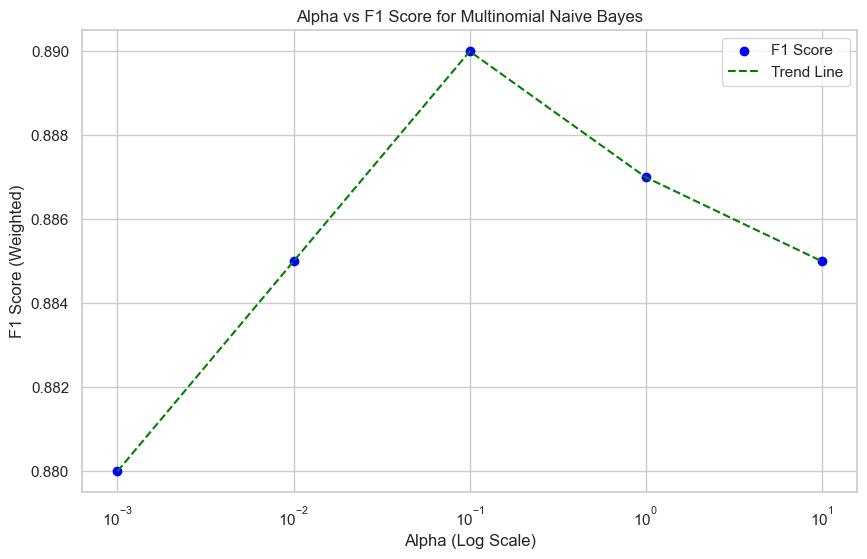

In [11]:
# Plot from your hyperparameter tuning results

alpha_values = [0.001, 0.01, 0.1, 1, 10] 
f1_scores = [0.88, 0.885, 0.89, 0.887, 0.885]  # Corresponding F1 scores

sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Scatter plot for Alpha vs F1 Score
plt.scatter(alpha_values, f1_scores, color='blue', label='F1 Score')

# Fit a smooth curve using a lineplot (for trend visualization)
plt.plot(alpha_values, f1_scores, color='green', linestyle='--', label='Trend Line')

# Set the axis labels and title
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('F1 Score (Weighted)')
plt.title('Alpha vs F1 Score for Multinomial Naive Bayes')

# Set the x-axis to logarithmic scale for better visualization
plt.xscale('log')

# Display a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [13]:
# Train the Naive Bayes model with the optimized hyperparameters
best_trial = study.best_trial

# Extract the best hyperparameters
alpha = best_trial.params['alpha']
fit_prior = best_trial.params['fit_prior']

# Ensure that the data does not contain negative values
X_train = X_train - X_train.min()  

# Initialize the MultinomialNB model with the best hyperparameters
nb_model = MultinomialNB(
    alpha=alpha,  
    fit_prior=fit_prior)

# Train the MultinomialNB model with the best hyperparameters
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=0.000301178495713505)

In [14]:
# Make predictions using the fitted model
y_pred = nb_model.predict(X_test)

### Evaluating the model with common evaluation metrics

In [15]:
# Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))



Model Evaluation Metrics:
Accuracy: 0.78
Precision: 0.91
Recall: 0.78
F1 Score: 0.84

Confusion Matrix:
[[16465  4013]
 [  676   524]]

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.96      0.80      0.88     20478
       Fraud       0.12      0.44      0.18      1200

    accuracy                           0.78     21678
   macro avg       0.54      0.62      0.53     21678
weighted avg       0.91      0.78      0.84     21678

